# COMP 527: Implementing the k-means clustering algorithm

> In the assignment, you are required to cluster words belonging to four categories: animals, countries, fruits and veggies. The words are arranged into four different files. The first entry in each line is a word followed by 300 features (word embedding) describing the meaning of that word.

## Implementation
 
> (1) Implement the k-means clustering algorithm with Euclidean distance to cluster the instances into k clusters. (30 marks)

First we define Word and Dataset classes to handle the data. For the specifics, see the source-code in `kmeans.py`.

In [1]:
import numpy as np                 # for handling vectors
import matplotlib.pyplot as plt    # for plotting results
import pandas as pd                # for neatly displaying results in table

from kmeans import Word, Dataset   # defined to handle data from files

In [2]:
words = Dataset(['animals','countries','fruits','veggies'])

Reading in data from animals.
Reading in data from countries.
Reading in data from fruits.
Reading in data from veggies.
'cucumber' is already named, but we add it again anyway.
You can remove with `.remove('cucumber')`


Then we define a `euclidean_distance()` function.

In [3]:
def euclidean_distance(u,v):
    """Return Euclidean distance between two np.array vectors."""
    
    return np.sqrt( (u - v).dot( u - v ))

In [4]:
a = np.array([0,1])
b = np.array([1,0])
print(euclidean_distance(a,b))

1.4142135623730951


The Euclidean distance between $[0, 1]$ and $[1,0]$ is, as we would expect, $\sqrt2$.

In [5]:
(cucumber_fruit, cucumber_veggie) = words.repeats()[0]

In [6]:
euclidean_distance(cucumber_fruit.vector, cucumber_veggie.vector)

0.0

We note that strictly speaking, `euclidean_distance()` is not a well-defined metric on the `words` set of data, since we have two different data-points with zero distance between them: cucumber labelled as fruit, and cucumber labelled as vegetable. (One way of dealing with this would be to somehow treat both cucumbers as a single data-point, but with two labels; another would be to choose one label over the other; yet another would be to remove one of the cucumbers. Here we simply note it, and continue.)

We now define a class to implement the K-Means algorithm.

In [7]:
class KMeans():
    
    def __init__(
                self, 
                k, 
                D, 
                metric = euclidean_distance, 
                normed = False, 
                max_iterations = 10**3, 
                seed = None,
                ):
        """
        Initialize KMeans Model.
        
        Args:
            k (int): number of clusters to divide data into.
            D (Dataset): as defined by Dataset() class.
            metric (function): to measure distance between points.
            norm (Boolean): whether or not to normalize vectors.
            iterations (int): when to stop if no convergence.
            seed (int): for reproducible (pseudo-)randomness.
        """
        
        self.k = k
        self.D = D
        self.normed = normed
        if self.normed == True:
            self.data = normalize(D.data)
        else:
            self.data = D.data
        
        self.metric = metric
                
        if seed:
            self.seed = seed
        else:
            self.seed = np.random.randint(0, 2**32)
        np.random.seed(seed)
        
        # we track centroid positions and cluster labels in nested dicts,
        # of the form dict_name[iteration_number][centroid_number]
        self._centroid = {}
        
        self._cluster = {}

        # we record cluster labels explicitly as well
        self._label = {}
        
        self.max_iterations = max_iterations
        for i in range(self.max_iterations):
            self._iteration = i
            self._iterate()
            if i > 0 and self._cluster[i] == self._cluster[i-1]:
                break
        
        self.cluster = self._cluster[self._iteration]
        self.label = self._label[self._iteration]
        
        self.convergence = self._iteration + 1
        if self.convergence == max_iterations:
            self.convergence = np.nan
        
        self._evaluate()
        
    def __repr__(self):
        """Representation of model."""
        
        desc = f"k = {self.k}"
    
    
    def _start(self):
        """Shuffle dataset and position centroids on first k datapoints."""
        
        # to avoid the situation where some clusters have no nearest points,
        # we start with cluster centroids positioned on randomly selected datapoints.
        selected = np.random.permutation(self.data)[0:self.k]
        
        self._centroid[0] = {}
        
        for centroid_number in range(self.k):
            self._centroid[0][centroid_number] = selected[centroid_number].vector
           
    
    def _classify(self):
        """Assign each data point to cluster of nearest centroid."""
        
        self._cluster[self._iteration] = {}
        self._label[self._iteration] = {}
        
        for centroid_number in range(self.k):
            self._cluster[self._iteration][centroid_number] = []
        
        for d in self.data:
            distances = [] 
            
            for centroid_number in range(self.k):
                
                distances.append(self.metric(d.vector, self._centroid[self._iteration][centroid_number]))
            
            closest_centroid = np.argmin(distances)
            
            self._cluster[self._iteration][closest_centroid].append(d)
            self._label[self._iteration][d.name] = closest_centroid
        
            
    def _reposition(self):
        """Move centroids to mean of each cluster."""
        
        for centroid_number in range(self.k):
            self._centroid[self._iteration] = {}
        
        for centroid_number in range(self.k):
            
            clustered = self._cluster[self._iteration - 1][centroid_number]
            
            if len(clustered) > 0:
                vector_sum = np.zeros(len(clustered[0].vector))
                
                for datum in clustered:
                    vector_sum += datum.vector

                cluster_mean = vector_sum / len(clustered)

                self._centroid[self._iteration][centroid_number] = cluster_mean

            else:
                # nothing assigned to this cluster so position is unchanged
                self._centroid[self._iteration][centroid_number] = \
                        self._centroid[self._iteration - 1][centroid_number]
           
   
    def _iterate(self):
        """Position centroids and classify data by nearest centroid."""
        
        if self._iteration == 0:
            self._start()
        else:
            self._reposition()
        
        self._classify()
            
            
    def _evaluate(self):
        """Evaluate success of clustering."""
        
        self.true_positives = 0
        self.true_negatives = 0
        self.false_positives = 0
        self.false_negatives = 0
        
        data = self.data
        
        for i in range(len(data)):
            for j in range(i+1, len(data)):
                if data[i].category == data[j].category \
                and self.label[data[i].name] == self.label[data[j].name]:
                    self.true_positives += 1
                if data[i].category != data[j].category \
                and self.label[data[i].name] == self.label[data[j].name]:
                    self.false_positives += 1
                if data[i].category != data[j].category \
                and self.label[data[i].name] != self.label[data[j].name]:
                    self.true_negatives += 1
                if data[i].category == data[j].category \
                and self.label[data[i].name] != self.label[data[j].name]:
                    self.false_negatives += 1
                    
        
        self.precision = self.true_positives / (self.true_positives + self.false_positives)
        self.recall = self.true_positives / (self.true_positives + self.false_negatives)
        self.f_score = 2 * self.precision * self.recall / (self.precision + self.recall)
        
        self.score = f'Precision: {self.precision}.\nRecall: {self.recall}.\nF-Score: {self.f_score}.\n'
        
    def describe(self):
        """Describe model clusters."""
        
        desc = ""
        for i in range(self.k):
            desc += f"Cluster {i} includes {len(self.cluster[i])} elements.\n"
            
            count = {}
            for category in self.D.categories:
                count[category] = 0
                for word in self.cluster[i]:
                    if word.category == category:
                        count[category] += 1
                if count[category] > 0:
                       desc += f"{count[category]} are {category}.\n"
            desc += '\n'
            
        print(f'K-Means Model\n\nParameters:\nk={self.k}\nD={self.D}\nmetric={self.metric}\nnormed={self.normed}\nseed={self.seed}\n')
        print(f'Converged after {self.convergence} iterations.\n')
        print(self.score)
        print(desc)

In [8]:
clustering = KMeans(k=4, D=words, metric=euclidean_distance, seed=29)
clustering.describe()

K-Means Model

Parameters:
k=4
D=Collection of 329 words from 4 categories, with 300-dimensional feature vectors.
metric=<function euclidean_distance at 0x7f26b6d04b90>
normed=False
seed=29

Converged after 8 iterations.

Precision: 0.9079803630551433.
Recall: 0.9074623459607485.
F-Score: 0.9077212806026366.

Cluster 0 includes 74 elements.
22 are fruits.
52 are veggies.

Cluster 1 includes 48 elements.
2 are animals.
2 are countries.
36 are fruits.
8 are veggies.

Cluster 2 includes 159 elements.
159 are countries.

Cluster 3 includes 48 elements.
48 are animals.




Our implementation appears to be working.

## Compute Precision, Recall, and F-Score

> (2) Vary the value of k from 1 to 10 and compute the precision, recall, and F-score for each set of clusters. Plot k in the horizontal axis and precision, recall and F-score in the vertical axis in the same plot. (10 marks)

Since we are asked multiple times for different metrics to vary the value of k, to compute precision/recall/f-scores, and to plot the values, we define a function to do this for us without unnecessary repetition.

In [9]:
# define functions to avoid repetition while doing requested tasks.

fig_num = 0

def get_scores(max_k, D, metric, normed=False, seed=1):
    "Get model scores for range of values of k."
    
    scores = {}
    scores['metric'] = f'{metric.__name__}, normed={normed}'
    measures = 'precision', 'recall', 'f_score'
    for measure in measures:
        scores[measure] = []
    model = {}
    for k in range(1, max_k+1):
        model[k] = KMeans(k=k, D=D, metric=metric, normed=normed, seed=seed)
        for measure in measures:
            scores[measure].append( getattr(model[k], measure) )
            
    return scores



def show_results(fig_num, scores):
    """Plot results for given scores and return scores as table."""

    measures = 'precision', 'recall', 'f_score'
    max_k = len(scores[measures[0]])
    
    fig, ax = plt.subplots(figsize=(15,8))

    for measure in measures:
        ax.plot(range(1,max_k + 1), scores[measure], label = measure)

    ax.set_xticks(range(1,max_k + 1))
    ax.set_xlabel('Number of Clusters (k)')
    ax.set_ylabel('Evaluation Score')
    ax.set_yticks(np.arange(0,max_k + 1)/max_k)
    ax.set_xlim(1,max_k)
    ax.set_ylim(0,1.01)
    plt.title(f'Figure {fig_num}: Comparison of Precision, Recall, and F-Scores for {scores["metric"]}',y=-0.15)
    ax.legend()
    plt.show()

    scores['k'] = list(range(1,10+1))
    scores.pop('metric')
    table = pd.DataFrame(scores).set_index('k')
    return table.transpose()

In [10]:
# explicitly set seed for reproducible pseudo-randomness
seed = 29

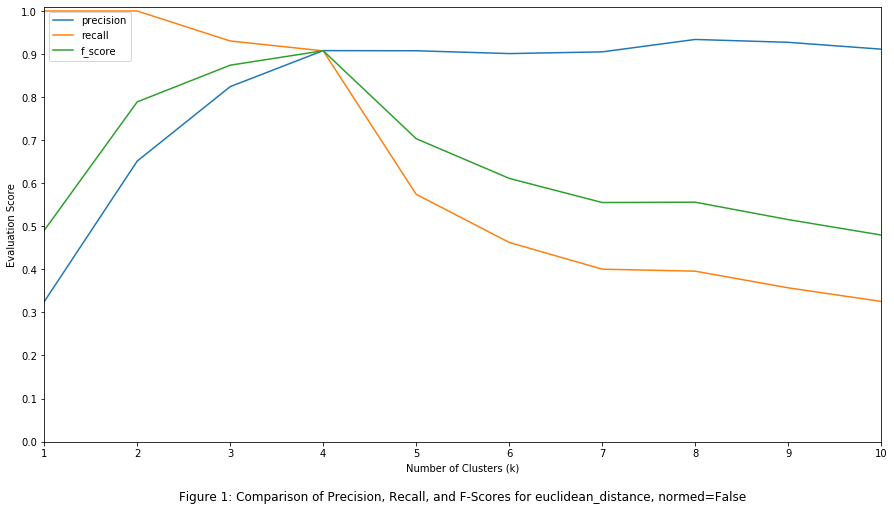

k,1,2,3,4,5,6,7,8,9,10
precision,0.324857,0.651405,0.824335,0.907980,0.907656,0.901078,0.905081,0.933899,0.927248,0.911342
recall,1.000000,1.000000,0.930340,0.907462,0.574224,0.462517,0.400388,0.395767,0.357029,0.325479
f_score,0.490403,0.788910,0.874136,0.907721,0.703428,0.611272,0.555178,0.555938,0.515550,0.479654


In [11]:
fig_num += 1
show_results(fig_num, get_scores(max_k=10, D=words, metric=euclidean_distance, seed=seed))

## Normalize

> (3) Now re-run the k-means clustering algorithm you implemented in part (1) but normalise each feature vector to unit $ L_2 $ length before computing Euclidean distances. Vary the value of k from 1 to 10 and compute the precision, recall, and F-score for each set of clusters. Plot k in the horizontal axis and precision, recall and F-score in the vertical axis in the same plot. (10 marks)

We define a function to normalize each feature vector to  unit $ L_2 $ length.

In [12]:
def normalize(data):
    """Return normalized vectors (ie. parallel vector with unit magnitude)."""
    
    normalized_data = []
    
    for d in data:
        normalized_vector = d.vector / np.sqrt( d.vector.dot(d.vector) )
        normalized_data.append(Word(d.name, normalized_vector, d.category))
        
    return normalized_data

In [13]:
print('Original Vector Magnitudes')
for word in words.data[:3]:
    print(f"{word.name}'s vector has magnitude {np.sqrt(word.dot(word))}" )
print('...')

print('Normalized Vector Magnitudes')
for word in normalize(words.data)[:3]:
    print(f"{word.name}'s vector has magnitude {np.sqrt(word.dot(word))}" )
print('...')

Original Vector Magnitudes
elephant's vector has magnitude 6.4487564189517705
leopard's vector has magnitude 7.139715219834713
dog's vector has magnitude 7.689131355830199
...
Normalized Vector Magnitudes
elephant's vector has magnitude 0.9999999999999999
leopard's vector has magnitude 0.9999999999999999
dog's vector has magnitude 0.9999999999999999
...


Our `normalize()` function seems to be working.

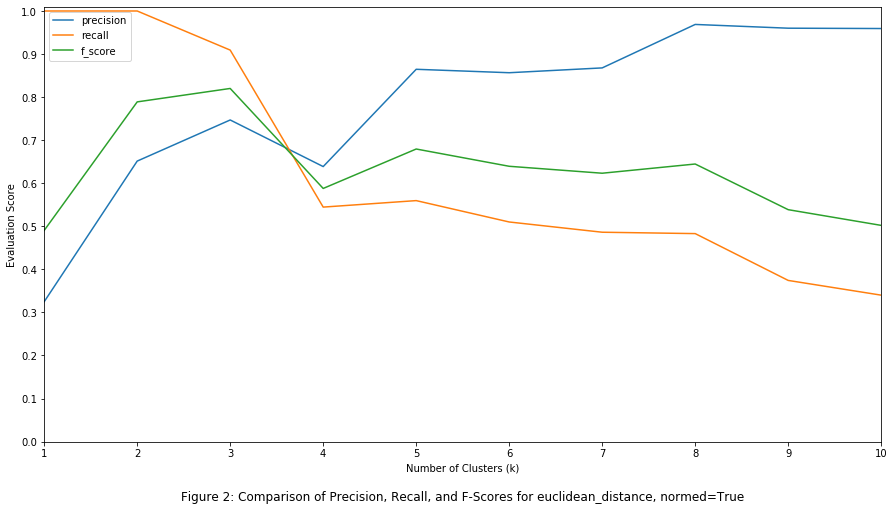

k,1,2,3,4,5,6,7,8,9,10
precision,0.324857,0.651405,0.746907,0.638675,0.864610,0.856636,0.867821,0.968761,0.960047,0.959279
recall,1.000000,1.000000,0.909174,0.544557,0.559619,0.509984,0.486194,0.482999,0.374258,0.340027
f_score,0.490403,0.788910,0.820091,0.587873,0.679458,0.639345,0.623227,0.644611,0.538566,0.502085


In [14]:
fig_num += 1
show_results(fig_num, get_scores(max_k=10, D=words, metric=euclidean_distance, normed=True, seed=seed))

## Manhattan Distance

> (4) Now re-run the k-means clustering algorithm you implemented in part (1) but this time use Manhattan distance over the unnormalised feature vectors. Vary the value of k from 1 to 10
and compute the precision, recall, and F-score for each set of clusters. Plot k in the horizontal axis and precision, recall and F-score in the vertical axis in the same plot. (10 marks)

We define a `manhattan_distance()` function:

In [15]:
def manhattan_distance(u,v):
    """Return Manhattan distance between two np.array vectors."""
    
    w = u - v
    distance = 0
    for x in w:
        distance += abs(x)
    
    return distance

In [16]:
print(a)
print(b)
print(manhattan_distance(a,b))

[0 1]
[1 0]
2


Our implementation appears to work: the distance between $[0,1]$ and $[1,0]$ is, as we would expect, $ 2 $.

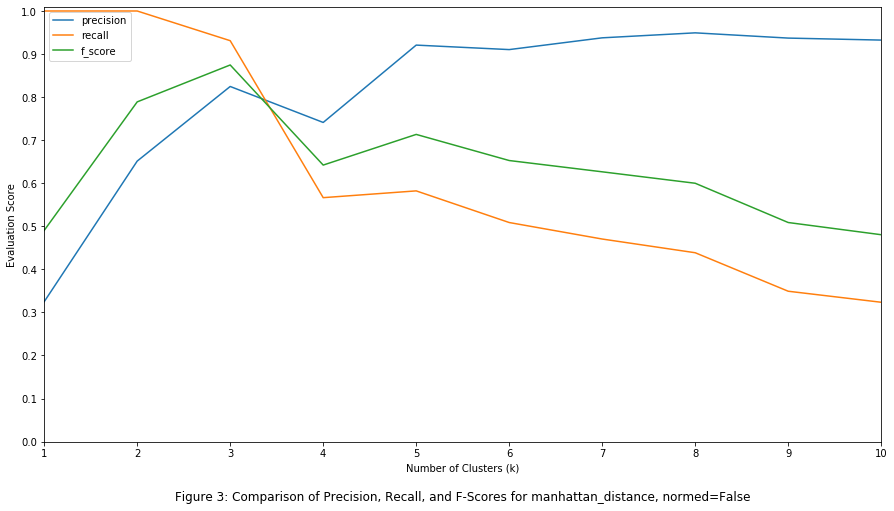

k,1,2,3,4,5,6,7,8,9,10
precision,0.324857,0.651405,0.824692,0.741136,0.920780,0.910362,0.937678,0.949247,0.937069,0.932424
recall,1.000000,1.000000,0.931025,0.566465,0.582211,0.508729,0.470390,0.438555,0.349156,0.323539
f_score,0.490403,0.788910,0.874638,0.642134,0.713362,0.652710,0.626496,0.599938,0.508749,0.480390


In [17]:
fig_num += 1
show_results(fig_num, get_scores(max_k=10, D=words, metric=manhattan_distance, normed=False, seed=seed))

## Normalized Manhattan Distance

> (5) Now re-run the k-means clustering algorithm you implemented in part (1) but this time use Manhattan distance with $ L_2 $ normalised feature vectors. Vary the value of k from 1 to 10 and
compute the precision, recall, and F-score for each set of clusters. Plot k in the horizontal axis and precision, recall and F-score in the vertical axis in the same plot. (10 marks)

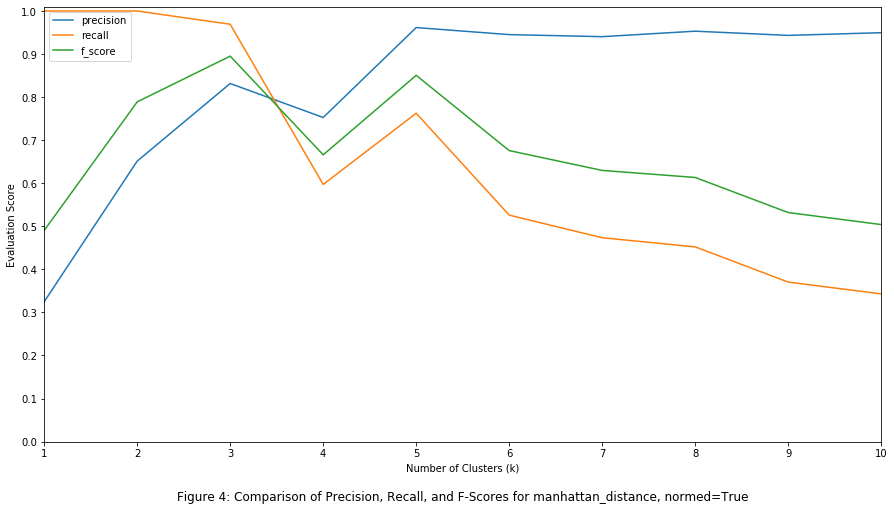

k,1,2,3,4,5,6,7,8,9,10
precision,0.324857,0.651405,0.831604,0.752643,0.961514,0.945145,0.940383,0.953102,0.943330,0.949613
recall,1.000000,1.000000,0.969192,0.597159,0.762551,0.525901,0.473357,0.452191,0.370379,0.342994
f_score,0.490403,0.788910,0.895142,0.665946,0.850552,0.675782,0.629729,0.613373,0.531913,0.503961


In [18]:
fig_num += 1
show_results(fig_num, get_scores(max_k=10, D=words, metric=manhattan_distance, normed=True, seed=seed))

##  Cosine Similarity

> (6) Now re-run the k-means clustering algorithm you implemented in part (1) but this time use cosine similarity as the distance (similarity) measure.Vary the value of k from 1 to 10 andcompute the precision, recall, and F-score for each set of clusters. Plot k in the horizontal axis and precision, recall and F-score in the vertical axis in the same plot. (10 marks)

Using cosine similarity directly with our k-means clustering algorithm will not work properly, as it is a *similarity measure* rather than a *distance measure*.

In [19]:
def cosine_similarity(u, v):
    """Return cosine similarity of two np.array vectors."""
    
    if np.array_equal(u, v):
        # we specify this to avoid rounding errors
        cos_theta = 1
    else:
        cos_theta = u.dot(v)/( np.sqrt(u.dot(u)) * np.sqrt(v.dot(v)) )
    
    return cos_theta

In [20]:
print(cosine_similarity(a,a))
print(cosine_similarity(a,b))

1
0.0


Our clustering algorithm relies upon a distance metric such that $ d(x,y) \to 0 $ as $ y \to x $, whereas cosine similarity gives us $sim(x,y) \to 1$ as $y \to x$.

Rather than rewriting our k-means algorithm, we will instead define `angular_distance()` in terms of `cosine_similarity()` and use that as our metric.

In [21]:
def angular_distance(u, v):
    """Return angular distance between two np.array vectors."""

    cos_theta = cosine_similarity(u, v)

    theta = np.arccos(cos_theta)
    
    if theta < 0:
        theta += 2 * np.pi
    
    return theta

In [22]:
print(a)
print(b)
print(angular_distance(a,a))
print(angular_distance(b,b))
print(angular_distance(a,b))

[0 1]
[1 0]
0.0
0.0
1.5707963267948966


Having seen that `angular_distance()` behaves suitably, we then plot its results.

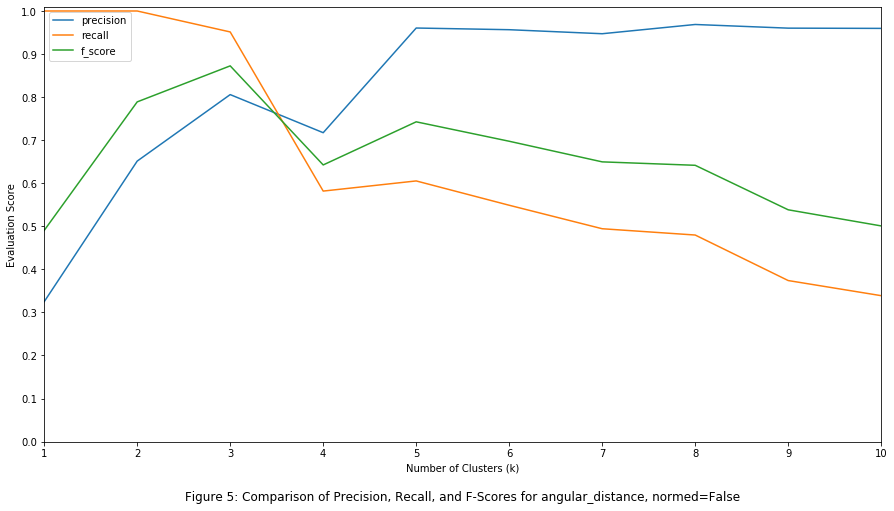

k,1,2,3,4,5,6,7,8,9,10
precision,0.324857,0.651405,0.805828,0.717341,0.960442,0.956548,0.947196,0.968664,0.960158,0.959606
recall,1.000000,1.000000,0.951335,0.581755,0.605317,0.548836,0.494295,0.479690,0.373973,0.338829
f_score,0.490403,0.788910,0.872557,0.642472,0.742607,0.697481,0.649597,0.641636,0.538288,0.500822


In [23]:
fig_num += 1
show_results(fig_num, get_scores(max_k = 10, D=words, metric=angular_distance, seed=seed))

## Compare and Discuss

> (7) Comparing the different clusterings you obtained in (2)-(6) discuss what is the best setting for k-means clustering for this dataset. (20 marks)

In [24]:
def compare_metrics(seed):
    """Return k=4 results for all metrics (normed and not), given seed."""
    
    metrics = euclidean_distance, manhattan_distance, angular_distance
    
    normed = False, True
    
    results = {}
    
    for m in metrics:
        for boolean in normed:
            if (m == angular_distance) and (boolean == True):
                # don't need to take norm for angular_distance
                pass
            else:
                results[f'{m.__name__}, normed={boolean}'] =\
                KMeans(k=4, D=words, metric=m, normed=boolean, max_iterations=100, seed=seed).f_score
    
    return results

In [25]:
results = compare_metrics(seed)

In [26]:
print(f'\nWith a randomising seed of {seed}, our best f-score was given by {max(results, key=lambda key: results[key])}')
pd.DataFrame(results,index=['f_score'])


With a randomising seed of 29, our best f-score was given by euclidean_distance, normed=False


,"euclidean_distance, normed=False","euclidean_distance, normed=True","manhattan_distance, normed=False","manhattan_distance, normed=True","angular_distance, normed=False"
f_score,0.907721,0.587873,0.642134,0.665946,0.642472


We know that our data should divide into four categories, so we are primarily interested in the case k=4. It seems like the best f-score is clearly given by `euclidean_distance()` when the data is not first regularized with the $ L_2 $ norm. Looking at the plots, we also see that this is the only case where the f-score peaks at k=4.

So *based on the clusterings obtained in tasks (2)-(6), that would seem to be the best setting for k-means clustering for this dataset*.

*However*, such a conclusion does not account for the possibility of our results being due to the idiosynchrasies of the initial random centroid positions.

We can investigate whether this is the case.

In [27]:
seeded_results = {}
for i in range(30):
    seeded_results[i] = compare_metrics(i)

In [28]:
table = pd.DataFrame(seeded_results).transpose()
table['best'] = table.idxmax(axis=1)

table = table.sort_values(table.columns[0], ascending=False)

table.index.name = 'seed'
table.reset_index(inplace=True)

In [29]:
print('Table: Cluster F-Scores for Different Metrics given Different Seeds')
table

Table: Cluster F-Scores for Different Metrics given Different Seeds


,seed,"euclidean_distance, normed=False","euclidean_distance, normed=True","manhattan_distance, normed=False","manhattan_distance, normed=True","angular_distance, normed=False",best
0,25,0.955827,0.926310,0.946709,0.972068,0.974981,"angular_distance, normed=False"
1,4,0.951888,0.960005,0.958406,0.961017,0.969215,"angular_distance, normed=False"
2,13,0.951727,0.963565,0.961017,0.961017,0.966422,"angular_distance, normed=False"
3,23,0.946924,0.963565,0.944333,0.960767,0.966422,"angular_distance, normed=False"
4,2,0.942758,0.961002,0.958384,0.969213,0.974981,"angular_distance, normed=False"
5,7,0.942758,0.958201,0.958201,0.960849,0.966422,"angular_distance, normed=False"
6,24,0.939274,0.960053,0.944162,0.683858,0.974981,"angular_distance, normed=False"
7,21,0.937913,0.672434,0.949567,0.797838,0.662653,"manhattan_distance, normed=False"
8,6,0.937709,0.649431,0.938577,0.972068,0.651866,"manhattan_distance, normed=True"
9,1,0.932914,0.958201,0.944333,0.960756,0.966422,"angular_distance, normed=False"


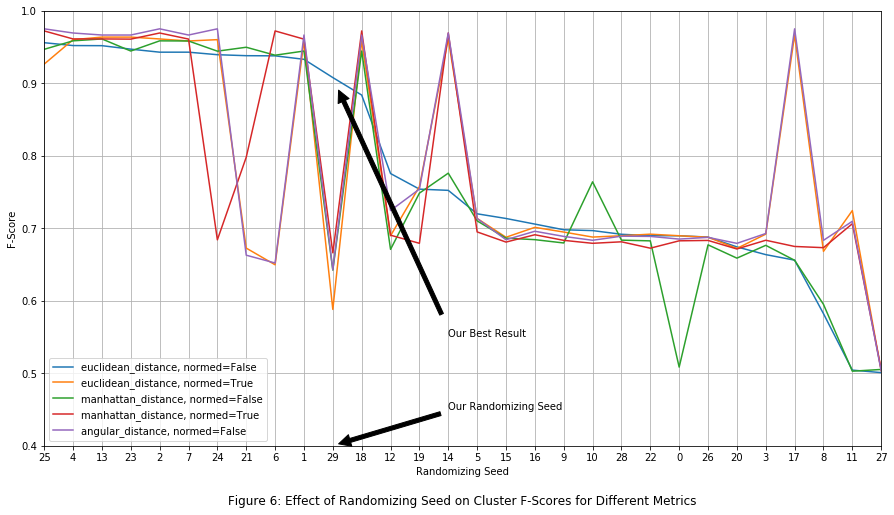

In [30]:
table[table.columns[1:]].plot(figsize=(15,8))
plt.ylim(0.4,1)
plt.xlim(0,29)
plt.xticks(range(0,30), labels=list(table.seed))
plt.grid(True)
plt.xlabel('Randomizing Seed')
plt.ylabel('F-Score')


our_case = table.loc[table.seed==seed].index.values
plt.annotate('Our Best Result', 
             xy=(our_case, table[table.iloc[our_case].best.values[0]][our_case]), 
             xytext=(14, 0.55),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )

plt.annotate('Our Randomizing Seed', 
             xy=(our_case, 0.4), 
             xytext=(14, 0.45),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )

fig_num += 1
plt.title(f'Figure {fig_num}: Effect of Randomizing Seed on Cluster F-Scores for Different Metrics',y=-0.15)
plt.show()

In [31]:
print('Table: Number of Times a Metric gives Best F-Score for Given Seed')
pd.DataFrame(table.best.value_counts())

Table: Number of Times a Metric gives Best F-Score for Given Seed


,best
"angular_distance, normed=False",13
"euclidean_distance, normed=False",9
"manhattan_distance, normed=False",3
"euclidean_distance, normed=True",3
"manhattan_distance, normed=True",2


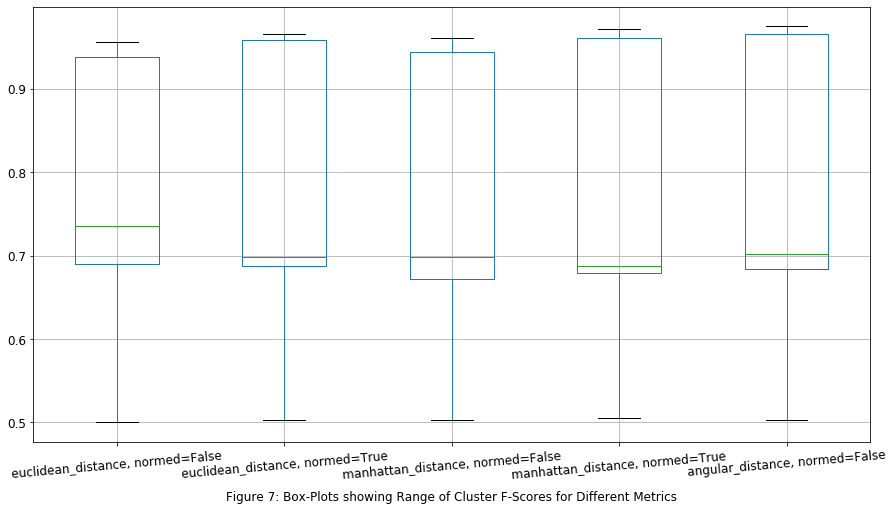

In [32]:
table[table.columns[1:]].boxplot(figsize=(15,8), rot=5, fontsize='large')
fig_num += 1
plt.title(f'Figure {fig_num}: Box-Plots showing Range of Cluster F-Scores for Different Metrics',y=-0.15)
plt.show()

Further analysis demonstrates that the superior performance of the clustering algorithm with the parameters `metric=euclidean_distance, normed=False`, was a fluke of the initial centroid positions generated by the randomizing seed (see Figure 6).

When we run the clustering algorithm with k=4, and the different combinations of metric and normed, using a range of different randomizing seeds (from 0 to 29), and compare f-scores, we find that it is actually `angular_distance` which returns the best f-score on the most occasions. (Aside: since the angular distance between two vectors should be unaffected by the vector's magnitudes, we only run the normed=False version for this case; if we did, we would actually find that slight rounding errors would give subtly different scores, but this is not what we are interested in.) We also see that every combination returns the best f-score on at least two occasions.

When we plot the range of f-score results for each metric/normed combination (Figure 7), we see that `metric=euclidean_distance, normed=False` had the best *median* result, but the worst maximum result. And this analysis is based only on thirty different possibilities, out of a set of $ {329 \choose 4 } = \frac{329!}{4!(329-4)!} = 479,318,126$ ways that we could choose 4 out of 329 datapoints on which to place our centroid's starting positions. So we cannot really say that any one metric/normed combination works best for this dataset -- all we can say is that one would be well advised to run the clustering algorithm with several different randomizing seeds.